In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#hierarchial clustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 

#lda stuff
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



# Dataframe 2019

this dataframe consists of up to date stasitcs of the 2019 season. The stats from this dataframe is included from basketball-reference satistcs per 100 team possessions and their advanced statistics. 538 raptor scor ratings are included in  this as well. 

Note: 538 raptor score ratings turn individual players into team talent estimates. The on/off ratpor scores evaluates how a player's team performs while he was on the floor, how the player's courtmates performed without player, how the courtmates' other courtmates performed when they were on the floor without player's courtmates. The raptor box scores takes into account individual player statistics. 

In [76]:
df19 = pd.read_csv('data/fixed19.csv')
#index_col = [0]
df19 = df19.iloc[:, :-3]
df19['G'] = df19['G'].astype(int)

In [77]:
df19.shape

(542, 208)

## Data Preprocessing

I'm dropping all players who haven't played more than 30 minutes. There has been less than 20 games per season so I am taking minutes into account

In [78]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [79]:
df_bline = (df19[df19['MP'] > 48])

In [80]:
df_bline.shape

(445, 208)

In [81]:
print(df_bline.columns.tolist())

['Unnamed: 0', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'salary', 'BSR Off.', 'BSR Def.', 'BSR Total', 'OOR Off.', 'OOR Def.', 'OOR Total', 'OVR Off.', 'OVR Def.', 'OVR total', 'WAR', 'Tm18', 'G18', 'GS18', 'MP18', 'FG18', 'FGA18', 'FG%18', '3P18', '3PA18', '3P%18', '2P18', '2PA18', '2P%18', 'FT18', 'FTA18', 'FT%18', 'ORB18', 'DRB18', 'TRB18', 'AST18', 'STL18', 'BLK18', 'TOV18', 'PF18', 'PTS18', 'ORtg18', 'DRtg18', 'PER18', 'TS%18', '3PAr18', 'FTr18', 'ORB%18', 'DRB%18', 'TRB%18', 'AST%18', 'STL%18', 'BLK%18', 'TOV%18', 'USG%18', 'OWS18', 'DWS18', 'WS18', 'WS/4818', 'OBPM18', 'DBPM18', 'BPM18', 'VORP18', 'Games1818', 'FB18', 'PAINTPTS18', 'TO_PTS18', '2ND_PTS18', 'Q1PTS18', 

In [82]:
df_bline = df_bline.drop(['Unnamed: 0', 'Games1818', 'url_list', '\xa0', '\xa0.1'], axis = 1)

### Quick feature engineering of specific values

There are some stats that are valuable on the court but low in numbers. For example, steals are valuable for any competitive game, but even the best players would have less than 3 steals per game. So we want to put more emphasis on these stats.

In [83]:
df_bline['AST_2x'] = (df_bline['AST'] * 2)
df_bline['STL_2x'] = (df_bline['STL'] * 2)
df_bline['BLK_2x'] = (df_bline['BLK'] * 2)

### Sorting features into categories

In [84]:
df_bline['TOV'].describe()

count    445.000000
mean       2.793708
std        1.295072
min        0.000000
25%        1.900000
50%        2.600000
75%        3.500000
max        8.200000
Name: TOV, dtype: float64

In [107]:
offensive = ['FG%', '3PA', '2PA', 'ORB', 'AST_2x', 'TOV',
            'ORtg', 'DRtg', '3PAr', 'ORB%', 'AST%', 'TOV%',
            'OWS', 'OBPM', 'BSR Off.', 'OOR Off.', 'OVR Off.',
            'WAR','WS/48', 'WS']

In [108]:
defensive = ['DRB', 'STL_2x', 'BLK_2x', 'DRtg', 'DRB%', 
            'BLK%', 'DWS', 'DBPM', 'BSR Def.', 'OOR Def.',
            'OVR Def.', 'VORP', 'WAR']

In [109]:
overall = ['FG', 'FT%', 'TRB', 'PER', 'TS%', 'TRB%',
          'WS/48', 'BPM', 'BSR Total', 'OOR Total',
          'OVR total', 'WAR', 'VORP']

### Offensive Practice

In [98]:
X = df_bline[offensive]
y = df_bline['Player']

#scale data
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [99]:
#dimensionality reduction
pca = PCA(n_components = 5)
pca.fit(X_sc)
X_pca = pca.transform(X_sc)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.8083967714449711


In [100]:
#creating clusters
km = KMeans(n_clusters = 10, random_state= 248)
km.fit(X_pca)
y_kmeans = km.predict(X_pca)
silhouette_score(X_sc, km.labels_)

0.12991450889179088

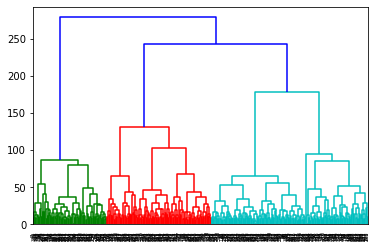

In [28]:
#hierarchial clustering
dn = sch.dendrogram(sch.linkage(X, method = 'ward'))

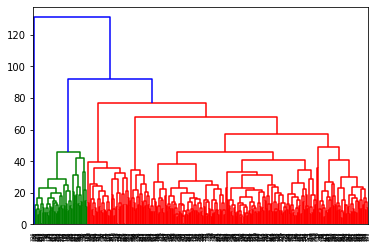

In [16]:
#hierarchial clustering
dn = sch.dendrogram(sch.linkage(X, method = 'complete'))

In [17]:
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
#stuck at this point in hierarcial clustering

### Defensive Practice

In [101]:
X = df_bline[defensive]
X_sc = sc.fit_transform(X)

#dimensionality reduction
pca = PCA(n_components = 5)
pca.fit(X_sc)
X_pca = pca.transform(X_sc)

In [102]:
#creating clusters
km = KMeans(n_clusters = 10, random_state= 248)
km.fit(X_pca)
y_kmeans = km.predict(X_pca)
silhouette_score(X_sc, km.labels_)

0.12687593016361423

### Overall Practice

In [103]:
X = df_bline[overall]
X_sc = sc.fit_transform(X)

#dimensionality reduction
pca = PCA(n_components = 5)
pca.fit(X_sc)
X_pca = pca.transform(X_sc)

#dimensionality reduction
pca = PCA(n_components = 5)
pca.fit(X_sc)
X_pca = pca.transform(X_sc)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.8457716118205094


In [104]:
#creating clusters
km = KMeans(n_clusters = 5, random_state = 248)
km.fit(X_pca)
y_kmeans = km.predict(X_pca)
silhouette_score(X_sc, km.labels_)

0.1706760018711229